# Variational inference using the finite approximation

In [20]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from copy import deepcopy

import VI_algorithms_lib
import valez_finite_VI_lib


# Draw data

In [27]:
np.random.seed(4368280)


Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = valez_finite_VI_lib.generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)

K_approx = deepcopy(K_inf) # variational truncation
print(Pi)

[ 0.64604807  0.96402149  0.89696843]


In [28]:
VI_instance = VI_algorithms_lib.VI_algorithms(X, K_approx, alpha, sigma_eps, sigma_A)

# Run CAVI with random restarts

In [29]:
n_restart = 20
elbo_end = np.array([])

for i in range(n_restart): 
    VI_instance.re_init() # re initialize
    [tau_tmp, nu_tmp, phi_mu_tmp, phi_var_tmp, elbo] \
        = VI_instance.run_cavi(max_iter=300, tol=1e-6, verbose = False) # run cavi
        
    elbo_end = np.append(elbo_end, elbo[-1])
    
    # see if posterior predictive is better than all previous ones
    if (i == 0) or np.all(elbo_end[i] > elbo_end[:i]): 
        tau = deepcopy(tau_tmp)
        nu = deepcopy(nu_tmp)
        phi_mu = deepcopy(phi_mu_tmp)
        phi_var = deepcopy(phi_var_tmp)
    
    
print('max elbo: ', np.max(elbo_end))
print('average elbo', np.mean(elbo_end))
print('median elbo', np.median(elbo_end))

#print(elbo_end)
#print(np.argmax(elbo_end))

elbo converged:  412526.087743
elbo converged:  418078.556422
elbo converged:  425469.628963
elbo converged:  418777.09824
elbo converged:  418069.017102
elbo converged:  417058.410034
elbo converged:  422206.071181
elbo converged:  417105.375198
elbo converged:  416453.340495
elbo converged:  401775.979586
elbo converged:  415145.290067
elbo converged:  421252.608872
elbo converged:  415424.836461
elbo converged:  406011.351862
elbo converged:  422432.90907
elbo converged:  421679.803422
elbo converged:  412786.501164
elbo converged:  412877.309163
elbo converged:  413801.723982
elbo converged:  421876.199146
max elbo:  425469.628963
average elbo 416540.404909
median elbo 417081.892616


Z (unpermuted): 
 [[0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]]
permutation:  [1 2 0]
Z (permuted) 
 [[1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]]
round_nu 
 [[ 1.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]
 [ 0.  1.  0.]]
l1 error (after permutation):  [0.57599999999999996, 0.053999999999999999, 0.57399999999999995]


true A (permuted): 
 [[-11.011001    -4.40191411]
 [  8.66621642  -3.54917854]
 [ 14.33514885  -0.60695861]]
phi_mu: 
 [[-14.29430815  -0.29064137]
 [ 11.92408488  -8.24071675]
 [  7.9915834    3.6902762 ]]


true Pi (permuted):  [ 0.64604807  0.96402149  0.89696843]
computed Pi:  [ 0.38136153  0.9623265   0.09385327]


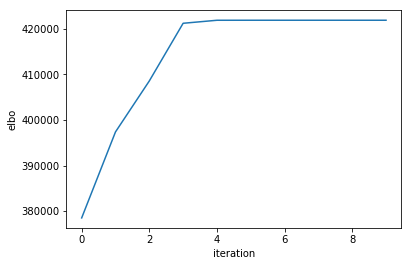

final elbo:  421876.199146


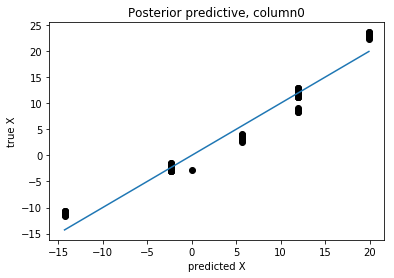

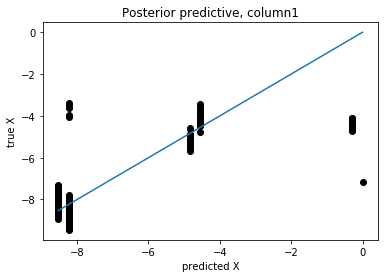

In [30]:
valez_finite_VI_lib.display_results(elbo, tau, nu, phi_mu, phi_var, X, Pi, Z, A)

# Run Stochastic VB 

In [31]:
VI_instance.re_init() # initialize

In [32]:
n_restart = 20
elbo_end = np.array([])

batch_size = 10

for i in range(n_restart): 
    VI_instance.re_init() # re initialize
    
    [tau, nu, phi_mu, phi_var, elbo] = \
        VI_instance.run_stochastic_VI(batch_size, decay_param = 0.9, max_iter=1500, tol=1e-4, verbose = False) 
        
    elbo_end = np.append(elbo_end, elbo[-1])
    
    # see if posterior predictive is better than all previous ones
    if (i == 0) or np.all(elbo_end[i] > elbo_end[:i]): 
        tau = deepcopy(tau_tmp)
        nu = deepcopy(nu_tmp)
        phi_mu = deepcopy(phi_mu_tmp)
        phi_var = deepcopy(phi_var_tmp)
    
    
print('max elbo: ', np.max(elbo_end))
print('average elbo', np.mean(elbo_end))
print('median elbo', np.median(elbo_end))



Max iteration reached; elbo:  405045.437888
Max iteration reached; elbo:  349986.751397
Max iteration reached; elbo:  403971.604425
Max iteration reached; elbo:  353374.119884
Max iteration reached; elbo:  402310.682655
elbo converged -162917.076604
Max iteration reached; elbo:  412698.707567
Max iteration reached; elbo:  394908.636907
Max iteration reached; elbo:  410522.370748
Max iteration reached; elbo:  402330.036517
Max iteration reached; elbo:  408799.321887
Max iteration reached; elbo:  402305.488508
elbo converged 349987.59507
Max iteration reached; elbo:  388727.450512
Max iteration reached; elbo:  404937.851507
Max iteration reached; elbo:  401076.11912
Max iteration reached; elbo:  377191.15519
Max iteration reached; elbo:  411765.902013
Max iteration reached; elbo:  403003.823496
elbo converged 411743.563335
max elbo:  412698.707567
average elbo 366588.477101
median elbo 402320.359586


Z (unpermuted): 
 [[0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]]
** procedure did not give a true permutation
permutation:  [0 1 2]
Z (permuted) 
 [[0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]]
round_nu 
 [[ 0.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 1.  0.  1.]
 [ 0.  0.  1.]
 [ 1.  0.  1.]]
l1 error (after permutation):  [0.062, 0.95399999999999996, 0.071997743657179425]


true A (permuted): 
 [[ 14.33514885  -0.60695861]
 [-11.011001    -4.40191411]
 [  8.66621642  -3.54917854]]
phi_mu: 
 [[  1.52237734e+01  -1.85483490e+00]
 [ -5.74464292e-15   3.89101435e-15]
 [ -3.06498820e+00  -6.90424002e+00]]


true Pi (permuted):  [ 0.64604807  0.96402149  0.89696843]
computed Pi:  [ 0.61756088  0.00660939  0.90375523]


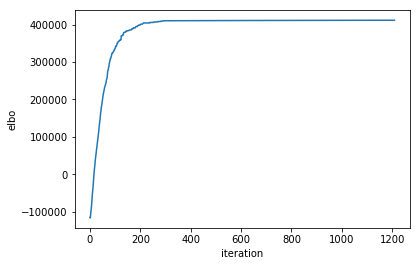

final elbo:  411743.563335


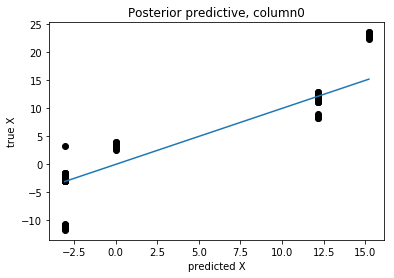

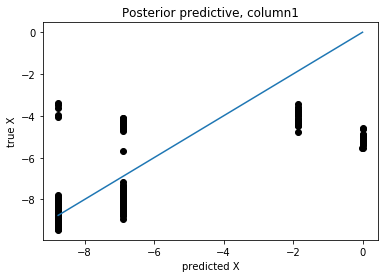

In [33]:
valez_finite_VI_lib.display_results(elbo, tau, nu, phi_mu, phi_var, X, Pi, Z, A)

# Gultekin: Annealing method

In [34]:
n_restart = 20
elbo_end = np.array([])

for i in range(n_restart): 
    VI_instance.re_init() # re initialize
    [tau_tmp, nu_tmp, phi_mu_tmp, phi_var_tmp, elbo] \
        = VI_instance.run_cavi_anneal(rho = 0.9, max_iter=500, tol=1e-6, verbose = False) # run cavi + annealing
        
    elbo_end = np.append(elbo_end, elbo[-1])
    
    # see if posterior predictive is better than all previous ones
    if (i == 0) or np.all(elbo_end[i] > elbo_end[:i]): 
        tau = deepcopy(tau_tmp)
        nu = deepcopy(nu_tmp)
        phi_mu = deepcopy(phi_mu_tmp)
        phi_var = deepcopy(phi_var_tmp)
    
    
print('max elbo: ', np.max(elbo_end))
print('average elbo', np.mean(elbo_end))
print('median elbo', np.median(elbo_end))

elbo converged:  417105.375198
elbo converged:  418078.556418
elbo converged:  421876.199142
elbo converged:  418777.098237
elbo converged:  422392.140782
elbo converged:  413670.306647
elbo converged:  377671.080032
elbo converged:  417105.375198
elbo converged:  361844.377224
elbo converged:  422206.071178
elbo converged:  419581.748951
elbo converged:  416917.703923
elbo converged:  412986.263143
elbo converged:  413317.420318
elbo converged:  413633.579313
elbo converged:  416336.39726
elbo converged:  373911.581785
elbo converged:  412526.087743
elbo converged:  418522.398761
elbo converged:  410732.721342
max elbo:  422392.140782
average elbo 409959.62413
median elbo 416627.050592


Z (unpermuted): 
 [[0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]]
permutation:  [0 2 1]
Z (permuted) 
 [[0 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]
 [0 1 1]
 [1 1 1]]
round_nu 
 [[ 0.  1.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  1.]
 [ 0.  1.  0.]]
l1 error (after permutation):  [0.626, 0.035999999999999997, 0.626]


true A (permuted): 
 [[ 14.33514885  -0.60695861]
 [  8.66621642  -3.54917854]
 [-11.011001    -4.40191411]]
phi_mu: 
 [[ 23.04827642  -4.09443313]
 [ 11.75938975  -8.26419417]
 [-13.80502489  -0.21131814]]


true Pi (permuted):  [ 0.64604807  0.96402149  0.89696843]
computed Pi:  [ 0.04230007  0.87706543  0.33179114]


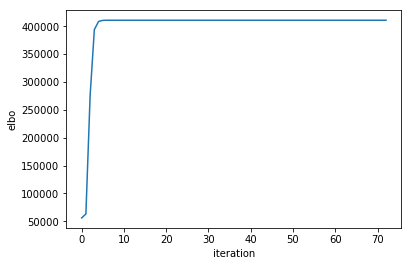

final elbo:  410732.721342


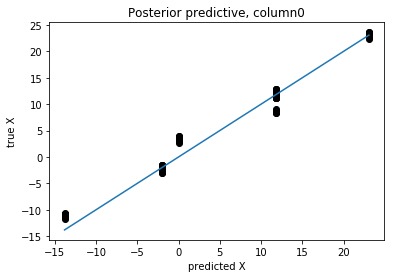

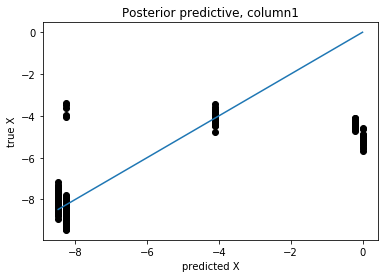

In [35]:
valez_finite_VI_lib.display_results(elbo, tau, nu, phi_mu, phi_var, X, Pi, Z, A)